In [3]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.linear_solver import pywraplp

In [25]:
import pandas as pd
import warnings
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [5]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [6]:
conda env list


Note: you may need to restart the kernel to use updated packages.

# conda environments:
#
                       C:\Users\Windows-HP\.ai-navigator\micromamba\envs\cpu
base                 * C:\Users\Windows-HP\anaconda3
optimization_project   C:\Users\Windows-HP\anaconda3\envs\optimization_project



In [7]:
n_sample = 100_000
chunk_size = 50_000
n_total = 1_000_000

In [11]:
print('mulai proses sampling data')
header = pd.read_csv('train.csv', nrows=0).columns.to_list()
chunks = []

for chunk in pd.read_csv('train.csv', chunksize=chunk_size, low_memory=False):
    print(f'chunk = {chunk} | total = {len(chunk)}')
    print(f'len(chunk)/n_total = {len(chunk)/n_total}')
    print(f'total chunk sample = {n_sample * (len(chunk)/n_total)}')
    chunks.append(chunk.sample(n=int(n_sample * (len(chunk)/n_total)), random_state=42))

mulai proses sampling data
chunk =               id  vendor_id      pickup_datetime     dropoff_datetime  \
0      id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1      id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2      id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3      id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4      id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   
...          ...        ...                  ...                  ...   
49995  id1731118          1  2016-06-11 18:59:08  2016-06-11 19:12:16   
49996  id2217585          2  2016-01-22 16:39:54  2016-01-22 16:46:37   
49997  id1002765          1  2016-02-05 22:07:29  2016-02-05 22:23:20   
49998  id1027192          2  2016-01-02 00:41:26  2016-01-02 01:10:46   
49999  id2537285          1  2016-01-14 08:03:52  2016-01-14 08:14:06   

       passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0       

## Explanatory Data Analysis (EDA)

In [14]:
df_sample = pd.concat(chunks, ignore_index=True)
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145864 entries, 0 to 145863
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  145864 non-null  object 
 1   vendor_id           145864 non-null  int64  
 2   pickup_datetime     145864 non-null  object 
 3   dropoff_datetime    145864 non-null  object 
 4   passenger_count     145864 non-null  int64  
 5   pickup_longitude    145864 non-null  float64
 6   pickup_latitude     145864 non-null  float64
 7   dropoff_longitude   145864 non-null  float64
 8   dropoff_latitude    145864 non-null  float64
 9   store_and_fwd_flag  145864 non-null  object 
 10  trip_duration       145864 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 12.2+ MB


In [15]:
df_sample.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id0004646,2,2016-04-11 11:28:00,2016-04-11 11:59:02,5,-73.862968,40.768719,-73.972672,40.755131,N,1862
1,id0135157,2,2016-01-31 00:26:11,2016-01-31 00:38:49,1,-74.007431,40.740749,-73.983261,40.748730,N,758
2,id2000923,2,2016-03-29 06:07:38,2016-03-29 06:09:03,5,-73.987869,40.765099,-73.993607,40.758949,N,85
3,id2747812,1,2016-06-13 22:17:27,2016-06-13 22:34:01,4,-74.015747,40.714695,-73.965248,40.767700,N,994
4,id2149383,2,2016-03-06 09:28:48,2016-03-06 09:32:56,2,-73.979324,40.784714,-73.971474,40.792526,N,248


In [16]:
df_sample.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

In [17]:
missing_mean = df_sample.isnull().mean() * 100
missing_sum = df_sample.isnull().sum()

print(f'rata-rata yang hilang = \n{missing_mean}')
print(f'\njumlah yang hilang = \n{missing_sum}')

rata-rata yang hilang = 
id                    0.0
vendor_id             0.0
pickup_datetime       0.0
dropoff_datetime      0.0
passenger_count       0.0
pickup_longitude      0.0
pickup_latitude       0.0
dropoff_longitude     0.0
dropoff_latitude      0.0
store_and_fwd_flag    0.0
trip_duration         0.0
dtype: float64

jumlah yang hilang = 
id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64


In [19]:
df_sample['pickup_datetime'] = pd.to_datetime(df_sample['pickup_datetime'])
df_sample['dropoff_datetime'] = pd.to_datetime(df_sample['dropoff_datetime'])

df_sample[['pickup_datetime', 'dropoff_datetime']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145864 entries, 0 to 145863
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   pickup_datetime   145864 non-null  datetime64[ns]
 1   dropoff_datetime  145864 non-null  datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 2.2 MB


In [20]:
df_sample.describe()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,145864.000000,145864,145864,145864.000000,145864.000000,145864.000000,145864.000000,145864.000000,145864.000000
mean,1.535862,2016-04-01 13:30:17.206438912,2016-04-01 13:46:13.399570688,1.665901,-73.973704,40.750825,-73.973762,40.751748,956.193132
min,1.000000,2016-01-01 00:00:53,2016-01-01 00:05:54,0.000000,-121.933235,37.389297,-121.933205,37.389103,1.000000
25%,1.000000,2016-02-17 22:12:31.500000,2016-02-17 22:24:55.750000128,1.000000,-73.991890,40.737247,-73.991364,40.735794,398.000000
50%,2.000000,2016-04-01 19:49:53,2016-04-01 20:03:13,1.000000,-73.981758,40.754066,-73.979881,40.754356,663.000000
75%,2.000000,2016-05-15 11:17:30.249999872,2016-05-15 11:29:59.249999872,2.000000,-73.967415,40.768269,-73.963173,40.769677,1076.000000
max,2.000000,2016-06-30 23:58:25,2016-07-01 19:54:54,6.000000,-73.312042,41.216953,-72.720734,41.319832,86385.000000
std,0.498714,NaN,NaN,1.318045,0.131658,0.029931,0.131071,0.033890,3195.869940


In [22]:
df_sample['pickup_hour'] = df_sample['pickup_datetime'].dt.hour
df_sample['pickup_day_of_week'] = df_sample['pickup_datetime'].dt.dayofweek # Senin=0, Minggu=6
df_sample['pickup_month'] = df_sample['pickup_datetime'].dt.month

df_sample.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,pickup_day_of_week,pickup_month
0,id0004646,2,2016-04-11 11:28:00,2016-04-11 11:59:02,5,-73.862968,40.768719,-73.972672,40.755131,N,1862,11,0,4
1,id0135157,2,2016-01-31 00:26:11,2016-01-31 00:38:49,1,-74.007431,40.740749,-73.983261,40.748730,N,758,0,6,1
2,id2000923,2,2016-03-29 06:07:38,2016-03-29 06:09:03,5,-73.987869,40.765099,-73.993607,40.758949,N,85,6,1,3
3,id2747812,1,2016-06-13 22:17:27,2016-06-13 22:34:01,4,-74.015747,40.714695,-73.965248,40.767700,N,994,22,0,6
4,id2149383,2,2016-03-06 09:28:48,2016-03-06 09:32:56,2,-73.979324,40.784714,-73.971474,40.792526,N,248,9,6,3


In [23]:
# jarak di permukaan bola/bumi
def haversine_distance(lon1, lat1, lon2, lat2):
    R = 6371  # Radius bumi dalam kilometer
    
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    distance = R * c
    return distance

In [31]:
df_sample['distance_km'] = haversine_distance(df_sample['pickup_longitude'], df_sample['pickup_latitude'],
                                             df_sample['dropoff_longitude'], df_sample['dropoff_latitude'])

df_sample.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,pickup_day_of_week,pickup_month,distance_km
0,id0004646,2,2016-04-11 11:28:00,2016-04-11 11:59:02,5,-73.862968,40.768719,-73.972672,40.755131,N,1862,11,0,4,9.362164
1,id0135157,2,2016-01-31 00:26:11,2016-01-31 00:38:49,1,-74.007431,40.740749,-73.983261,40.748730,N,758,0,6,1,2.221132
2,id2000923,2,2016-03-29 06:07:38,2016-03-29 06:09:03,5,-73.987869,40.765099,-73.993607,40.758949,N,85,6,1,3,0.837276
3,id2747812,1,2016-06-13 22:17:27,2016-06-13 22:34:01,4,-74.015747,40.714695,-73.965248,40.767700,N,994,22,0,6,7.269020
4,id2149383,2,2016-03-06 09:28:48,2016-03-06 09:32:56,2,-73.979324,40.784714,-73.971474,40.792526,N,248,9,6,3,1.091554


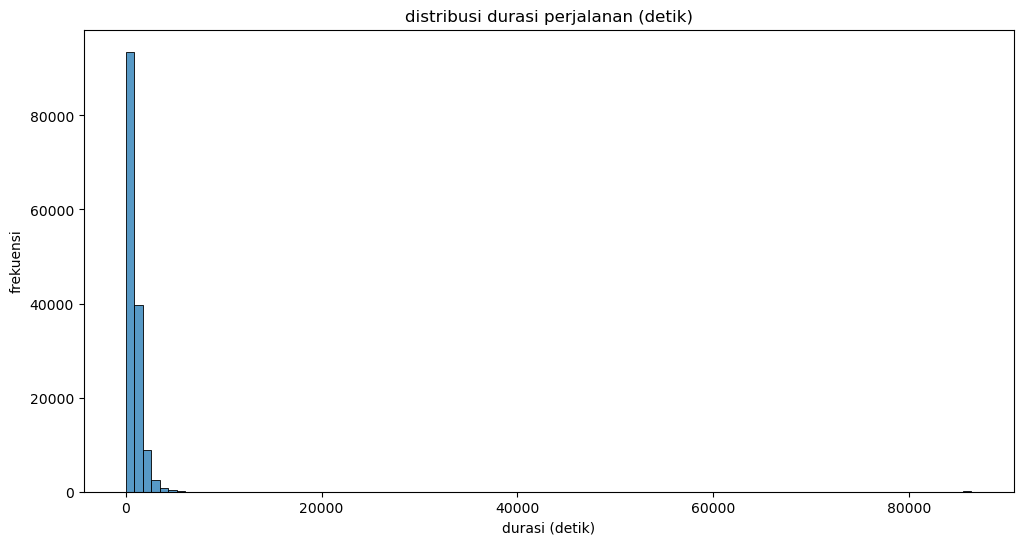

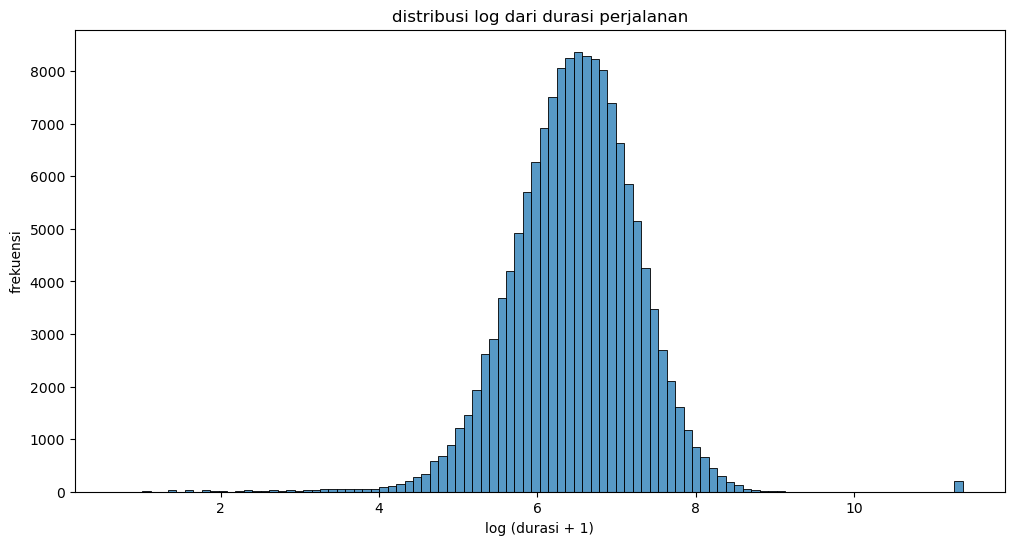

In [32]:
# distribusi durasi perjalanan (target)
plt.figure(figsize=(12,6))
sns.histplot(df_sample.trip_duration, bins=100)
plt.title('distribusi durasi perjalanan (detik)')
plt.xlabel('durasi (detik)')
plt.ylabel('frekuensi')
plt.show()

plt.figure(figsize=(12,6))
sns.histplot(np.log1p(df_sample.trip_duration), bins=100)
plt.title('distribusi log dari durasi perjalanan')
plt.xlabel('log (durasi + 1)')
plt.ylabel('frekuensi')
plt.show()

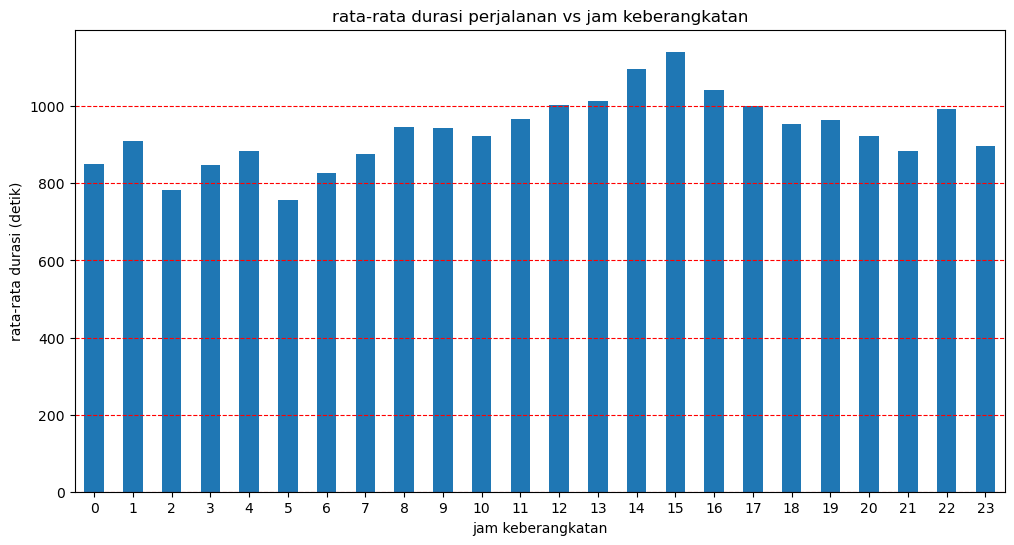

In [34]:

# distribusi perjalanan rata-rata berdasarkan jam keberangkatan
plt.figure(figsize=(12,6))
df_sample.groupby('pickup_hour')['trip_duration'].mean().plot(kind='bar')
plt.title('rata-rata durasi perjalanan vs jam keberangkatan')
plt.xlabel('jam keberangkatan')
plt.ylabel('rata-rata durasi (detik)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', color='red')
plt.show()

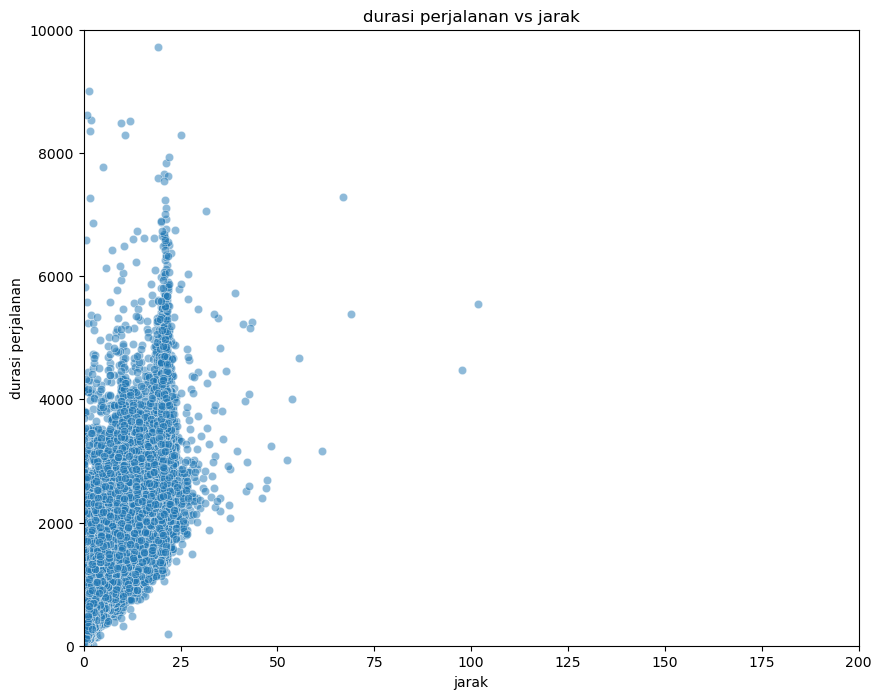

In [195]:
plt.figure(figsize=(10,8))
sns.scatterplot(x='distance_km', y='trip_duration', data=df_sample, alpha=0.5)
plt.title('durasi perjalanan vs jarak')
plt.xlabel('jarak')
plt.ylabel('durasi perjalanan')
plt.ylim(0, 10_000)
plt.xlim(0, 200)
plt.show()

In [196]:
df_sample.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_hour', 'pickup_day_of_week', 'pickup_month',
       'distance_km', 'duration_hour', 'speed_kmh'],
      dtype='object')

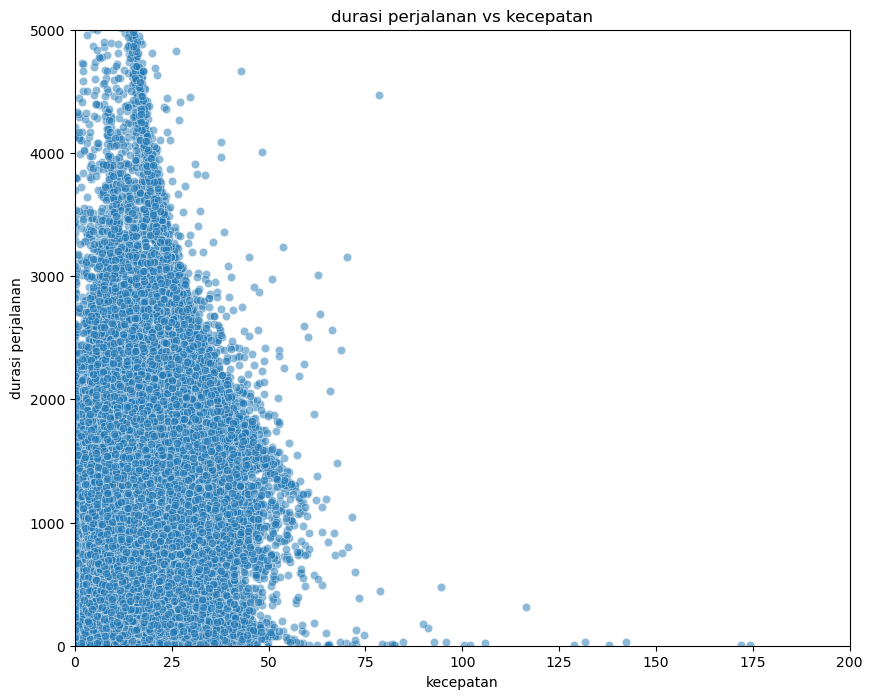

In [214]:
plt.figure(figsize=(10,8))
sns.scatterplot(x='speed_kmh', y='trip_duration', data=df_sample, alpha=0.5)
plt.title('durasi perjalanan vs kecepatan')
plt.xlabel('kecepatan')
plt.ylabel('durasi perjalanan')
plt.ylim(0, 5_000)
plt.xlim(0, 200)
plt.show()

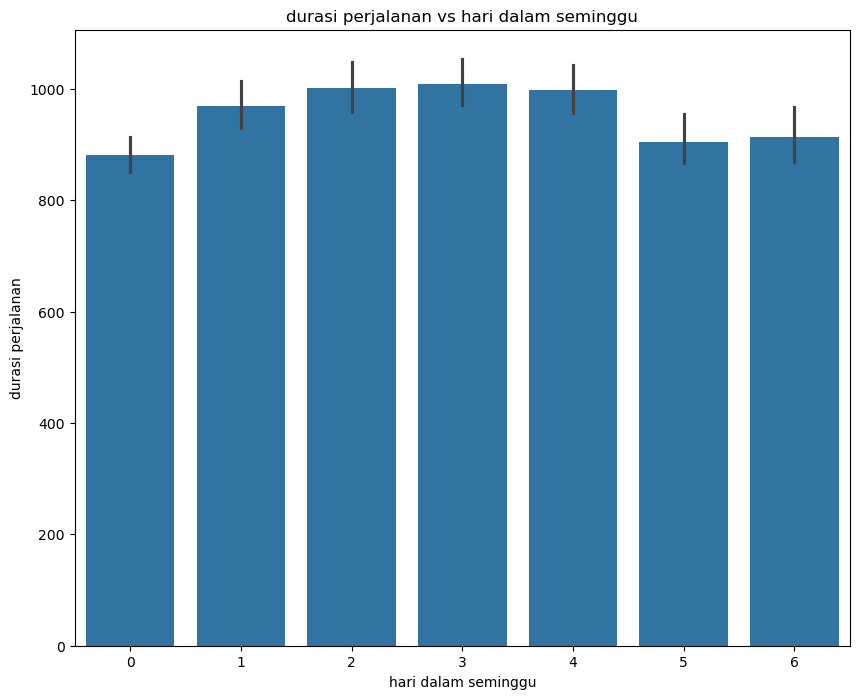

In [209]:
plt.figure(figsize=(10,8))
sns.barplot(x='pickup_day_of_week', y='trip_duration', data=df_sample)
plt.title('durasi perjalanan vs hari dalam seminggu')
plt.xlabel('hari dalam seminggu')
plt.ylabel('durasi perjalanan')
plt.show()

In [210]:
def second_conversion(second):
    second = int(second)
    
    hour = second // 3600
    remain_sec = second % 3600
    minute = remain_sec // 60
    end_sec = remain_sec % 60
    
    return f'{hour} jam {minute} menit, {end_sec} detik'

duration_1 = 758	
duration_2 = 80000

print(f'{duration_1} detik = {second_conversion(duration_1)}')
print(f'{duration_2} detik = {second_conversion(duration_2)}')


758 detik = 0 jam 12 menit, 38 detik
80000 detik = 22 jam 13 menit, 20 detik


In [37]:
import datetime

In [39]:
td_1 = datetime.timedelta(seconds=duration_1)
td_2 = datetime.timedelta(seconds=duration_2)

print(f'{duration_1} detik = {td_1}')
print(f'{duration_2} detik = {td_2}')

598 detik = 0:09:58
1157 detik = 0:19:17


In [41]:
df_sample.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_hour', 'pickup_day_of_week', 'pickup_month',
       'distance_km'],
      dtype='object')

In [44]:
duration_mean = df_sample.groupby('pickup_hour')['trip_duration'].mean()

for hour, duration in duration_mean.items():
    print(f'jam {hour:02d} : {int(duration)} detik --> {second_conversion(duration)}')
    
df_sample['duration_hour'] = df_sample['trip_duration'] / 3600
df_sample['speed_kmh'] = df_sample['distance_km'] / df_sample['duration_hour'].replace(0,0.00001)
df_sample.head()

jam 00 : 850 detik --> 0 jam 14 menit, 10 detik
jam 01 : 909 detik --> 0 jam 15 menit, 9 detik
jam 02 : 783 detik --> 0 jam 13 menit, 3 detik
jam 03 : 846 detik --> 0 jam 14 menit, 6 detik
jam 04 : 883 detik --> 0 jam 14 menit, 43 detik
jam 05 : 757 detik --> 0 jam 12 menit, 37 detik
jam 06 : 825 detik --> 0 jam 13 menit, 45 detik
jam 07 : 876 detik --> 0 jam 14 menit, 36 detik
jam 08 : 947 detik --> 0 jam 15 menit, 47 detik
jam 09 : 944 detik --> 0 jam 15 menit, 44 detik
jam 10 : 922 detik --> 0 jam 15 menit, 22 detik
jam 11 : 967 detik --> 0 jam 16 menit, 7 detik
jam 12 : 1003 detik --> 0 jam 16 menit, 43 detik
jam 13 : 1012 detik --> 0 jam 16 menit, 52 detik
jam 14 : 1096 detik --> 0 jam 18 menit, 16 detik
jam 15 : 1141 detik --> 0 jam 19 menit, 1 detik
jam 16 : 1041 detik --> 0 jam 17 menit, 21 detik
jam 17 : 999 detik --> 0 jam 16 menit, 39 detik
jam 18 : 954 detik --> 0 jam 15 menit, 54 detik
jam 19 : 964 detik --> 0 jam 16 menit, 4 detik
jam 20 : 921 detik --> 0 jam 15 menit, 21

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,pickup_day_of_week,pickup_month,distance_km,duration_hour,speed_kmh
0,id0004646,2,2016-04-11 11:28:00,2016-04-11 11:59:02,5,-73.862968,40.768719,-73.972672,40.755131,N,1862,11,0,4,9.362164,0.517222,18.100855
1,id0135157,2,2016-01-31 00:26:11,2016-01-31 00:38:49,1,-74.007431,40.740749,-73.983261,40.748730,N,758,0,6,1,2.221132,0.210556,10.548914
2,id2000923,2,2016-03-29 06:07:38,2016-03-29 06:09:03,5,-73.987869,40.765099,-73.993607,40.758949,N,85,6,1,3,0.837276,0.023611,35.461114
3,id2747812,1,2016-06-13 22:17:27,2016-06-13 22:34:01,4,-74.015747,40.714695,-73.965248,40.767700,N,994,22,0,6,7.269020,0.276111,26.326429
4,id2149383,2,2016-03-06 09:28:48,2016-03-06 09:32:56,2,-73.979324,40.784714,-73.971474,40.792526,N,248,9,6,3,1.091554,0.068889,15.845145


In [47]:
df_sample['speed_kmh'].describe()

count    145864.000000
mean         14.380599
std           8.755929
min           0.000000
25%           9.088885
50%          12.767013
75%          17.820591
max         926.765395
Name: speed_kmh, dtype: float64

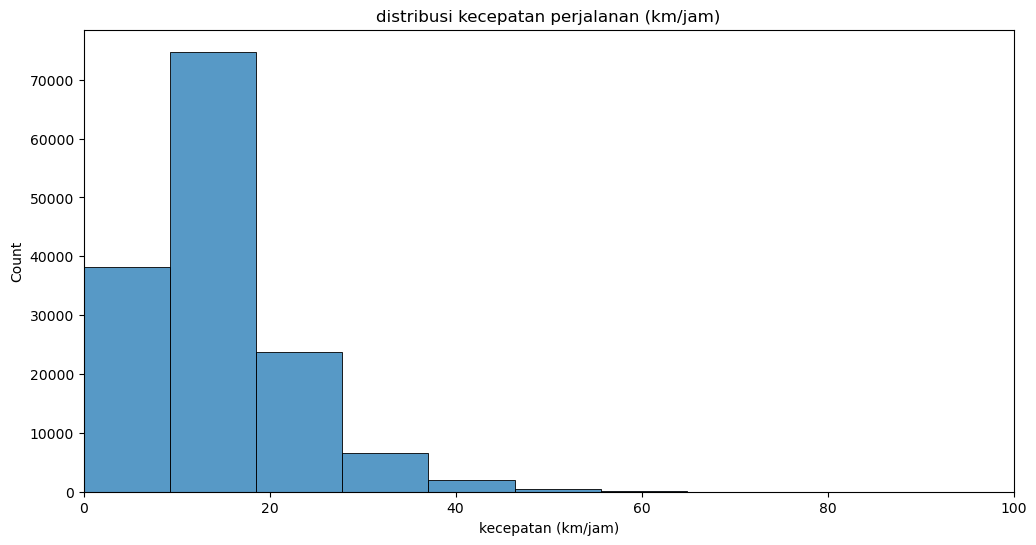

In [48]:
plt.figure(figsize=(12,6))
sns.histplot(data=df_sample, x='speed_kmh', bins=100)
plt.title('distribusi kecepatan perjalanan (km/jam)')
plt.xlabel('kecepatan (km/jam)')
plt.xlim(0,100)
plt.show()


In [49]:
df_cleaned = df_sample[
            (df_sample['trip_duration'] > 60) &
            (df_sample['trip_duration'] < 3600 * 6) &
            (df_sample['distance_km'] > 0)
        ]

60 detik = 0 jam 1 menit, 0 detik


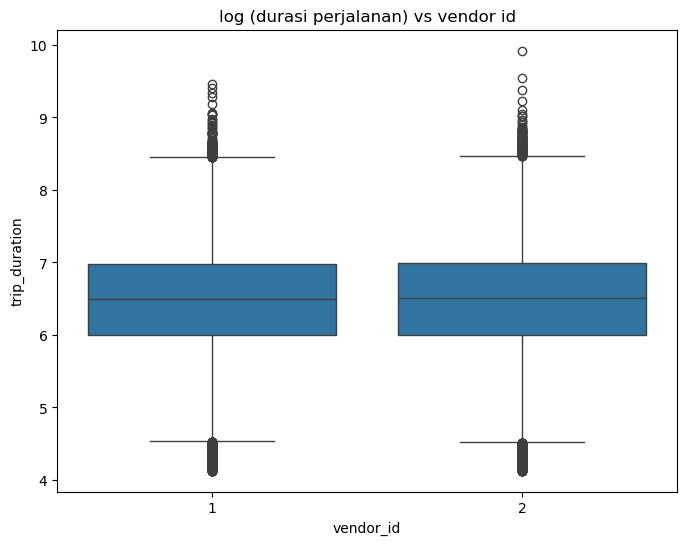

In [50]:
print(f'60 detik = {second_conversion(60)}')

plt.figure(figsize=(8,6))
sns.boxplot(x='vendor_id', y=np.log1p(df_cleaned.trip_duration), data=df_cleaned)
plt.title('log (durasi perjalanan) vs vendor id')
plt.show()

## Machine Learning

In [51]:
import shap
import joblib

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error, mean_squared_error, mean_squared_log_error


In [55]:
n_sample = 200_0000
df_raw = pd.read_csv('train.csv', nrows=n_sample)
df_test_raw = pd.read_csv('test.csv').copy()


In [63]:
print('jumlah baris data df_raw =',len(df_raw))
df_raw.head()

jumlah baris data df_raw = 1458644


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [67]:
df_2 = df_raw[(df_raw.trip_duration > 60) & (df_raw.trip_duration < 3600 * 6)].copy()

print(f'jumlah baris data df_2 = {len(df_2):_}')
print(f'jumlah baris data yang di hapus = {len(df_raw) - len(df_2):_}')
df_2.head()

jumlah baris data df_2 = 1_447_806
jumlah baris data yang di hapus = 10_838


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [68]:
df_2.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

In [112]:
df_2['pickup_datetime'] = pd.to_datetime(df_2.pickup_datetime)
df_2['pickup_hour'] = df_2.pickup_datetime.dt.hour
df_2['pickup_day_of_week'] = df_2.pickup_datetime.dt.dayofweek

df_test_raw['pickup_datetime'] = pd.to_datetime(df_test_raw.pickup_datetime)
df_test_raw['pickup_hour'] = df_test_raw.pickup_datetime.dt.hour
df_test_raw['pickup_day_of_week'] = df_test_raw.pickup_datetime.dt.dayofweek

In [113]:
print('df_2 =\n',df_2.info())
print()
print('df_test_raw =\n',df_test_raw.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1447806 entries, 0 to 1458643
Data columns (total 19 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   id                     1447806 non-null  object        
 1   vendor_id              1447806 non-null  int64         
 2   pickup_datetime        1447806 non-null  datetime64[ns]
 3   dropoff_datetime       1447806 non-null  object        
 4   passenger_count        1447806 non-null  int64         
 5   pickup_longitude       1447806 non-null  float64       
 6   pickup_latitude        1447806 non-null  float64       
 7   dropoff_longitude      1447806 non-null  float64       
 8   dropoff_latitude       1447806 non-null  float64       
 9   store_and_fwd_flag     1447806 non-null  object        
 10  trip_duration          1447806 non-null  int64         
 11  distance_km            1447806 non-null  float64       
 12  bearing                1447806 no

In [114]:
df_2.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance_km,bearing,pickup_cluster,dropoff_cluster,route_cluster,route_cluster_encoded,pickup_hour,pickup_day_of_week
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1.498521,99.970196,5,14,5_14,156,17,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.805507,-117.153768,10,8,10_8,28,0,6
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,6.385098,-159.680165,5,4,5_4,159,11,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1.485498,-172.737700,8,4,8_4,204,19,2
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1.188588,179.473585,6,6,6_6,176,13,5


In [115]:
R = 6371
lon1,lat1,lon2,lat2 = map(np.radians, [df_2.pickup_longitude, df_2.pickup_latitude, 
                                       df_2.dropoff_longitude, df_2.dropoff_latitude])

lon1_test, lat1_test, lon2_test, lat2_test = map(np.radians, [df_test_raw.pickup_longitude, df_test_raw.pickup_latitude, 
                                                              df_test_raw.dropoff_longitude, df_test_raw.dropoff_latitude])

In [116]:
dlon = lon2-lon1
dlat = lat2-lat1
dlon_test = lon2_test - lon1_test
dlat_test = lat2_test - lat1_test

print(f'''
dlon = \n{dlon}\n
dlat = \n{dlat}\n
dlat_test = \n{dlat_test}\n
dlon_test = \n{dlon_test}
''')


dlon = 
0          0.000306
1         -0.000333
2         -0.000459
3         -0.000039
4          0.000002
             ...   
1458639   -0.000222
1458640    0.000537
1458641   -0.000791
1458642    0.000130
1458643    0.000117
Length: 1447806, dtype: float64

dlat = 
0         -0.000041
1         -0.000129
2         -0.000940
3         -0.000231
4         -0.000187
             ...   
1458639   -0.000093
1458640    0.000858
1458641   -0.001072
1458642    0.000140
1458643    0.000154
Length: 1447806, dtype: float64

dlat_test = 
0         0.000430
1        -0.000429
2        -0.000141
3        -0.000723
4        -0.000097
            ...   
625129    0.000149
625130    0.000675
625131   -0.000195
625132    0.002762
625133    0.000916
Length: 625134, dtype: float64

dlon_test = 
0        -0.000036
1         0.000077
2         0.000197
3        -0.000530
4         0.000152
            ...   
625129    0.000039
625130    0.000924
625131    0.001670
625132    0.002133
625133    0.000219
L

In [117]:
a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
df_2['distance_km'] = R * 2 * np.arcsin(np.sqrt(a)) # rasio --> sudut

a_test = np.sin(dlat_test/2.0)**2 + np.cos(lat1_test) * np.cos(lat2_test) * np.sin(dlon_test/2.0)**2
df_test_raw['distance_km'] = R * 2 * np.arcsin(np.sqrt(a_test))


In [118]:
df_2.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance_km,bearing,pickup_cluster,dropoff_cluster,route_cluster,route_cluster_encoded,pickup_hour,pickup_day_of_week
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1.498521,99.970196,5,14,5_14,156,17,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.805507,-117.153768,10,8,10_8,28,0,6
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,6.385098,-159.680165,5,4,5_4,159,11,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1.485498,-172.737700,8,4,8_4,204,19,2
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1.188588,179.473585,6,6,6_6,176,13,5


In [119]:
y_dir = np.sin(dlon) * np.cos(lat2)
X_dir = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dlon)
y_dir_test = np.sin(dlon_test) * np.cos(lat2_test)
X_dir_test = np.cos(lat1_test) * np.sin(lat2_test) - np.sin(lat1_test) * np.cos(lat2_test) * np.cos(dlon_test)

In [120]:
df_2['bearing'] = np.degrees(np.arctan2(y_dir, X_dir))
df_test_raw['bearing'] = np.degrees(np.arctan2(y_dir_test, X_dir_test))

In [121]:
df_2[['pickup_latitude', 'pickup_longitude']]

,pickup_latitude,pickup_longitude
0,40.767937,-73.982155
1,40.738564,-73.980415
2,40.763939,-73.979027
3,40.719971,-74.010040
4,40.793209,-73.973053
...,...,...
1458639,40.745522,-73.982201
1458640,40.747379,-74.000946
1458641,40.768799,-73.959129
1458642,40.749062,-73.982079


In [122]:
coords = np.vstack((df_2[['pickup_latitude', 'pickup_longitude']],
                    df_2[['dropoff_latitude', 'dropoff_longitude']]))

coords

array([[ 40.76793671, -73.98215485],
       [ 40.73856354, -73.98041534],
       [ 40.7639389 , -73.97902679],
       ...,
       [ 40.70737076, -74.00443268],
       [ 40.75710678, -73.97463226],
       [ 40.79058456, -73.97280884]])

In [123]:
kmeans_model = MiniBatchKMeans(n_clusters=15, batch_size=256, random_state=42, n_init='auto')
kmeans_model.fit(coords)

,n_clusters,15
,init,'k-means++'
,max_iter,100
,batch_size,256
,verbose,0
,compute_labels,True
,random_state,42
,tol,0.0
,max_no_improvement,10
,init_size,None
,n_init,'auto'


In [124]:
df_2.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'distance_km', 'bearing', 'pickup_cluster',
       'dropoff_cluster', 'route_cluster', 'route_cluster_encoded',
       'pickup_hour', 'pickup_day_of_week'],
      dtype='object')

In [125]:
df_2['pickup_cluster'] = kmeans_model.predict(df_2[['pickup_latitude', 'pickup_longitude']])
df_2['dropoff_cluster'] = kmeans_model.predict(df_2[['dropoff_latitude', 'dropoff_longitude']])
df_test_raw['pickup_cluster'] = kmeans_model.predict(df_test_raw[['pickup_latitude', 'pickup_longitude']])
df_test_raw['dropoff_cluster'] = kmeans_model.predict(df_test_raw[['dropoff_latitude', 'dropoff_longitude']])

In [126]:
df_2.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance_km,bearing,pickup_cluster,dropoff_cluster,route_cluster,route_cluster_encoded,pickup_hour,pickup_day_of_week
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1.498521,99.970196,5,14,5_14,156,17,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.805507,-117.153768,10,8,10_8,28,0,6
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,6.385098,-159.680165,5,4,5_4,159,11,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1.485498,-172.737700,8,4,8_4,204,19,2
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1.188588,179.473585,6,6,6_6,176,13,5


In [127]:
df_2['route_cluster'] = df_2['pickup_cluster'].astype(str) + '_' + df_2['dropoff_cluster'].astype(str)
df_test_raw['route_cluster'] = df_test_raw['pickup_cluster'].astype(str) + '_' + df_test_raw['dropoff_cluster'].astype(str)

In [128]:
df_2.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance_km,bearing,pickup_cluster,dropoff_cluster,route_cluster,route_cluster_encoded,pickup_hour,pickup_day_of_week
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1.498521,99.970196,5,14,5_14,156,17,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.805507,-117.153768,10,8,10_8,28,0,6
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,6.385098,-159.680165,5,4,5_4,159,11,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1.485498,-172.737700,8,4,8_4,204,19,2
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1.188588,179.473585,6,6,6_6,176,13,5


In [129]:
le = LabelEncoder()
df_2['route_cluster_encoded'] = le.fit_transform(df_2.route_cluster)
df_test_raw['route_cluster_encoded'] = le.fit_transform(df_test_raw.route_cluster)

In [101]:
df_2.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance_km,bearing,pickup_cluster,dropoff_cluster,route_cluster,route_cluster_encoded
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1.498521,99.970196,5,14,5_14,156
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.805507,-117.153768,10,8,10_8,28
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,6.385098,-159.680165,5,4,5_4,159
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1.485498,-172.737700,8,4,8_4,204
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1.188588,179.473585,6,6,6_6,176


In [131]:
final_features = [
        'vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
        'dropoff_longitude', 'dropoff_latitude', 'pickup_hour', 'pickup_day_of_week',
        'distance_km', 'bearing', 'pickup_cluster', 'dropoff_cluster', 'route_cluster_encoded'
    ]

len(final_features)


13

In [133]:
print(df_2.columns, len(df_2.columns))
print()
print(df_test_raw.columns, len(df_test_raw.columns))

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'distance_km', 'bearing', 'pickup_cluster',
       'dropoff_cluster', 'route_cluster', 'route_cluster_encoded',
       'pickup_hour', 'pickup_day_of_week'],
      dtype='object') 19

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'distance_km', 'bearing',
       'pickup_cluster', 'dropoff_cluster', 'route_cluster',
       'route_cluster_encoded', 'pickup_hour', 'pickup_day_of_week'],
      dtype='object') 17


In [137]:
X = df_2[final_features]
y = np.log1p(df_2.trip_duration)
X_test_final = df_test_raw[final_features]

X.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_hour,pickup_day_of_week,distance_km,bearing,pickup_cluster,dropoff_cluster,route_cluster_encoded
0,2,1,-73.982155,40.767937,-73.964630,40.765602,17,0,1.498521,99.970196,5,14,156
1,1,1,-73.980415,40.738564,-73.999481,40.731152,0,6,1.805507,-117.153768,10,8,28
2,2,1,-73.979027,40.763939,-74.005333,40.710087,11,1,6.385098,-159.680165,5,4,159
3,2,1,-74.010040,40.719971,-74.012268,40.706718,19,2,1.485498,-172.737700,8,4,204
4,2,1,-73.973053,40.793209,-73.972923,40.782520,13,5,1.188588,179.473585,6,6,176


In [139]:
print("Data sudah siap.")

Data sudah siap.


In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
for i in [X_train, X_test, y_train, y_test]:
    i.reset_index(drop=True, inplace=True)
print("Data training & testing sudah siap.")

Data training & testing sudah siap.


In [142]:
nyc_bounds = {
        'min_lon' : -74.05, 'max_lon': -73.75,
        'min_lat': 40.6, 'max_lat': 40.9
    }

In [143]:
cluster_centers = kmeans_model.cluster_centers_
print(cluster_centers)

[[ 40.74399166 -73.99733913]
 [ 40.66433104 -73.78952916]
 [ 40.77665108 -73.95546531]
 [ 40.76526787 -73.86600645]
 [ 40.70730471 -74.02123562]
 [ 40.76586135 -73.98334908]
 [ 40.78741157 -73.97419373]
 [ 40.81669803 -73.9443717 ]
 [ 40.72374921 -73.99553554]
 [ 40.75187448 -73.97954502]
 [ 40.73523503 -73.98137808]
 [ 40.67278968 -73.96821933]
 [ 40.75758396 -73.9933786 ]
 [ 40.74553788 -73.91681737]
 [ 40.76042789 -73.96834557]]


In [ ]:
plt.figure(figsize=(12,12))
sns.scatterplot(x='pickup_longitude', y='pickup_latitude', data=df_2, s=1, alpha=1, color='blue')

plt.scatter(cluster_centers[:, 1], cluster_centers[:, 0], s=100, c='red', marker='X', label='centroid')

for i, centroid in enumerate(cluster_centers):
    plt.text(centroid[1], centroid[0], str(i), fontsize=10, c='black', weight='bold')

        
plt.title('peta persebaran titik penjemputan dengan centroid')
plt.xlabel('Bujur (Longitude)')
plt.ylabel('Lintang (Latitude)')
plt.xlim(nyc_bounds['min_lon'], nyc_bounds['max_lon'])
plt.ylim(nyc_bounds['min_lat'], nyc_bounds['max_lat'])
plt.show()

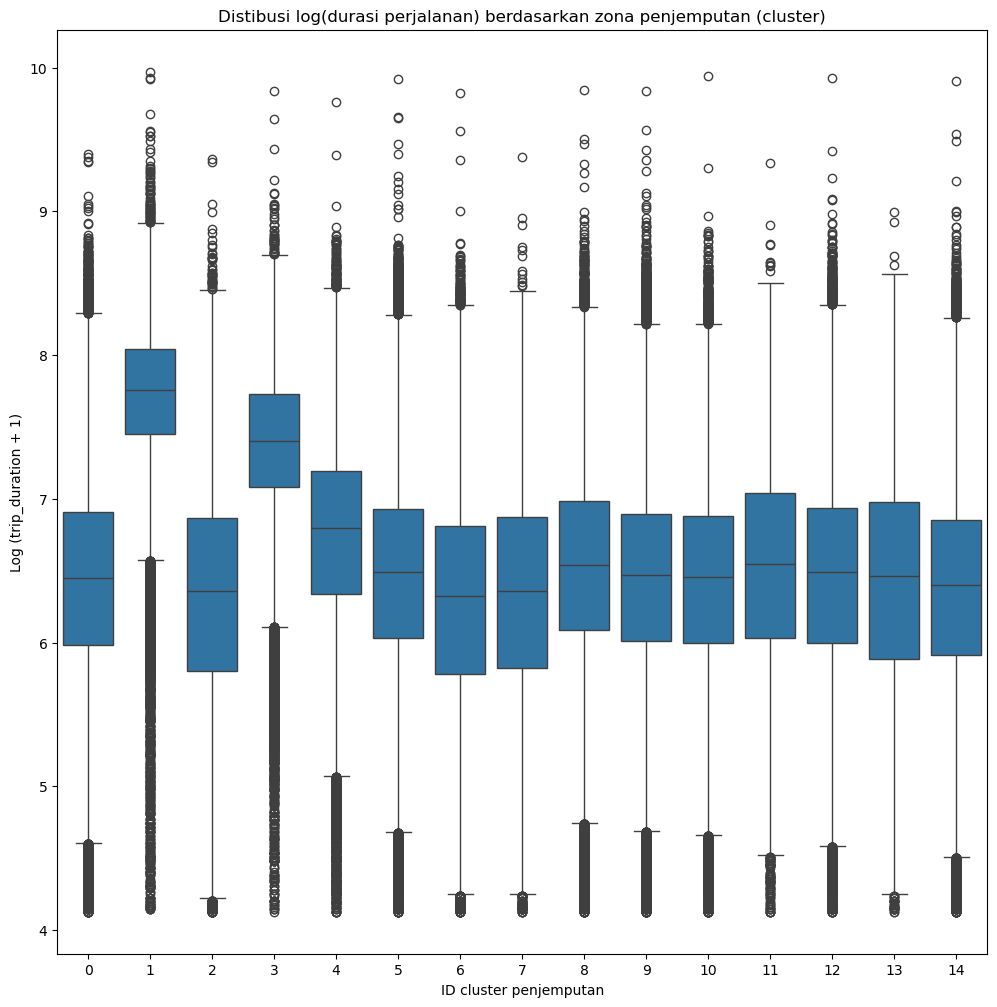

In [154]:
plt.figure(figsize=(12,12))
sns.boxplot(x='pickup_cluster', data=df_2, y=y)
plt.title('Distibusi log(durasi perjalanan) berdasarkan zona penjemputan (cluster)')
plt.xlabel('ID cluster penjemputan')
plt.ylabel('Log (trip_duration + 1)')
plt.show()

In [161]:
models = {
        # "RandomForest": RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1),
        "Lasso": Lasso(random_state=42),
        "Ridge": Ridge(random_state=42),
        "LinearRegresion": LinearRegression(),
        "XGBoost":XGBRegressor(n_jobs=-1, random_state=42),
        "LightGBM":LGBMRegressor(n_jobs=-1, random_state=42),
        "MLP": MLPRegressor(max_iter=300, hidden_layer_sizes=(32,16), random_state=42)
    }

In [162]:
scaling_need = ['MLP', 'Lasso', 'Ridge', 'LinearRegression']
result_list = []

In [163]:
print("\nMemulai proses perbandingan model dengan Cross-Validation...")

for name, model in models.items():
    print(f"  - Mengevaluasi: {name}")
    
    if name in scaling_need:
        print(f'scalng_need = {name}')
        eval_pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('model', model)
            ])
    else:
        eval_pipeline = model
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scoring_metrics = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
    
    cv_results = cross_validate(eval_pipeline, X, y, cv=kf, scoring=scoring_metrics, n_jobs=-1)
    
    r2_mean = np.mean(cv_results['test_r2'])
    rmsle_mean = np.sqrt(-np.mean(cv_results['test_neg_mean_squared_error']))
    mae_mean = -np.mean(cv_results['test_neg_mean_absolute_error'])
    mse_mean = -np.mean(cv_results['test_neg_mean_squared_error'])
    fit_time = np.mean(cv_results['fit_time'])
    
    result_list.append({
            'Model': name,
            'R2_mean': r2_mean,
            'RMSLE_mean': rmsle_mean,
            'MAE_log_mean': mae_mean,
            'MSE_log_mean':mse_mean,
            'Fit_time_s': fit_time
        })
    
print("Proses perbandingan model selesai.")


Memulai proses perbandingan model dengan Cross-Validation...
  - Mengevaluasi: Lasso
scalng_need = Lasso
  - Mengevaluasi: Ridge
scalng_need = Ridge
  - Mengevaluasi: LinearRegresion
  - Mengevaluasi: XGBoost
  - Mengevaluasi: LightGBM
  - Mengevaluasi: MLP
scalng_need = MLP
Proses perbandingan model selesai.


In [164]:
df_results = pd.DataFrame(result_list).sort_values(by='R2_mean', ascending=False).reset_index(drop=True)

print('\n' + '='*80)
print("HASIL PERBANDINGAN PERFORMA MODEL (PENDEKATAN FUNGSI)")
print('='*80)
print(df_results)



HASIL PERBANDINGAN PERFORMA MODEL (PENDEKATAN FUNGSI)
             Model   R2_mean  RMSLE_mean  MAE_log_mean  MSE_log_mean  \
0          XGBoost  0.802588    0.323539      0.236996      0.104677   
1         LightGBM  0.790392    0.333383      0.246195      0.111144   
2              MLP  0.623872    0.446593      0.265038      0.199445   
3            Ridge  0.366612    0.579581      0.428542      0.335914   
4  LinearRegresion  0.366612    0.579581      0.428542      0.335914   
5            Lasso -0.000001    0.728184      0.582149      0.530252   

   Fit_time_s  
0   19.297989  
1   27.615514  
2  349.404107  
3    2.186344  
4    1.717908  
5    4.754033  


In [165]:
print("\n--- Kesimpulan Awal ---")
top_pipeline = df_results.iloc[0]
best_model_name = top_pipeline['Model']
best_r2_score = top_pipeline['R2_mean']
best_rmsle_score = top_pipeline['RMSLE_mean']
best_mae_score = top_pipeline['MAE_log_mean']
best_mse_score = top_pipeline['MSE_log_mean']
best_fit_time = top_pipeline['Fit_time_s']
print(f'''
      model_name : {best_model_name}
      best_r2_score : {best_r2_score:.2f}
      best_rmsle_score : {best_rmsle_score:.2f}
      best_mae_score : {best_mae_score:.2f}
      best_mse_score : {best_mse_score:.2f}
      best_fit_time : {best_fit_time:.2f}
      ''')



--- Kesimpulan Awal ---

      model_name : XGBoost
      best_r2_score : 0.80
      best_rmsle_score : 0.32
      best_mae_score : 0.24
      best_mse_score : 0.10
      best_fit_time : 19.30
      


In [166]:
models_tune = {
        'XGBoost':{
                'model': XGBRegressor(random_state=42, n_jobs=-1),
                'params': {
                        'n_estimators': [100,200,300,500],
                        'learning_rate': [0.01, 0.05, 0.1],
                        'max_depth':[3,5,7,9],
                        'colsample_bytree': [0.7, 0.8, 0.9],
                        'subsample': [0.7,0.8,0.9]
                    }
            },
        'LightGBM':{
                'model' : LGBMRegressor(random_state=42, n_jobs=-1),
                'params': {
                        'n_estimators':[100,200,300,500],
                        'learning_rate':[0.01, 0.05, 0.1],
                        'max_depth': [-1, 5, 10],
                        'num_leaves': [20, 31, 40],
                        'colsample_bytree': [0.7, 0.8, 0.9],
                        'subsample': [0.7,0.8,0.9]
                    }
            }
    }

In [167]:
tuning_results = []

for name, config in models_tune.items():
    print(f'\n--- Tuning = {name} ---')
    
    random_search = RandomizedSearchCV(config['model'], 
                               config['params'],
                               n_jobs=-1,
                               verbose=1,
                               n_iter=10,
                               random_state=42,
                               scoring='r2',
                               cv=3)
    
    random_search.fit(X_train, y_train)
    
    tuning_results.append({
            'Model': name,
            'Best_score_r2': random_search.best_score_,
            'Best_params': random_search.best_params_
        })


--- Tuning = XGBoost ---
Fitting 3 folds for each of 10 candidates, totalling 30 fits

--- Tuning = LightGBM ---
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1826
[LightGBM] [Info] Number of data points in the train set: 1158244, number of used features: 13
[LightGBM] [Info] Start training from score 6.480485


In [168]:
print('\n--- Hasil hyperparameter tuning komparatif ---')
df_results = pd.DataFrame(tuning_results).sort_values(by='Best_score_r2', ascending=False)
print(df_results)

top_model = df_results.iloc[0]
best_model_name = top_model['Model']
best_score_r2 = top_model['Best_score_r2']
best_params = top_model['Best_params']

print(f'\nModel terbaik = {best_model_name} ({best_score_r2})')


--- Hasil hyperparameter tuning komparatif ---
      Model  Best_score_r2                                        Best_params
0   XGBoost       0.813300  {'subsample': 0.8, 'n_estimators': 200, 'max_d...
1  LightGBM       0.807514  {'subsample': 0.8, 'num_leaves': 31, 'n_estima...

Model terbaik = XGBoost (0.8133001371611578)


In [169]:
print('--- Melatih model pilihan pada data training ---')

if best_model_name == 'XGBoost':
    tune_model = XGBRegressor(**best_params, random_state=42, n_jobs=-1)
elif best_model_name == 'LightGBM':
    tune_model = LGBMRegressor(**best_params, random_state=42, n_jobs=-1)

tune_model.fit(X_train, y_train)

--- Melatih model pilihan pada data training ---


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [170]:
print('\n Evaluasi Performa Model (X_test)')
y_pred = tune_model.predict(X_test)
y_pred[y_pred < 0] = 0

y_test_ori = np.expm1(y_test)
y_pred_ori = np.expm1(y_pred)

final_rmsle = np.sqrt(mean_squared_log_error(y_test_ori, y_pred_ori))
final_r2 = r2_score(y_test_ori, y_pred_ori)
final_mae = mean_absolute_error(y_test_ori, y_pred_ori)
final_mse = mean_squared_error(y_test_ori, y_pred_ori)

print(f'final_rmsle = {final_rmsle:.2f}')
print(f'final_r2 = {final_r2:.2f}')
print(f'final_mae = {final_mae:.2f} detik')
print(f'final_mse = {final_mse:.2f}')



 Evaluasi Performa Model (X_test)
final_rmsle = 0.31
final_r2 = 0.79
final_mae = 174.12 detik
final_mse = 93340.20


In [171]:
print("--- Membuat Prediksi & Submission ---")

tune_model.fit(X, y)

y_pred_final = tune_model.predict(X_test_final)
y_pred_backlog = np.expm1(y_pred_final)
y_pred_backlog[y_pred_backlog < 0] = 0

result_final = {
        'id' : df_test_raw['id'],
        'trip_duration': y_pred_backlog
    }

result_final

--- Membuat Prediksi & Submission ---


{'id': 0         id3004672
 1         id3505355
 2         id1217141
 3         id2150126
 4         id1598245
             ...    
 625129    id3008929
 625130    id3700764
 625131    id2568735
 625132    id1384355
 625133    id0621643
 Name: id, Length: 625134, dtype: object,
 'trip_duration': array([ 838.98065,  572.0711 ,  392.6852 , ..., 1652.763  , 1873.1619 ,
        1182.0386 ], dtype=float32)}

In [241]:
y_pred_log = tune_model.predict(X_test)
residuals = y_test - y_pred_log

y_pred_log

array([6.146905 , 6.379312 , 6.966373 , ..., 5.5348063, 6.445808 ,
       5.739013 ], dtype=float32)

In [174]:
df_error_analysis = X_test.copy()
df_error_analysis['log_trip_duration_actual'] = y_test
df_error_analysis['log_trip_duration_pred'] = y_pred_log
df_error_analysis['error'] = residuals

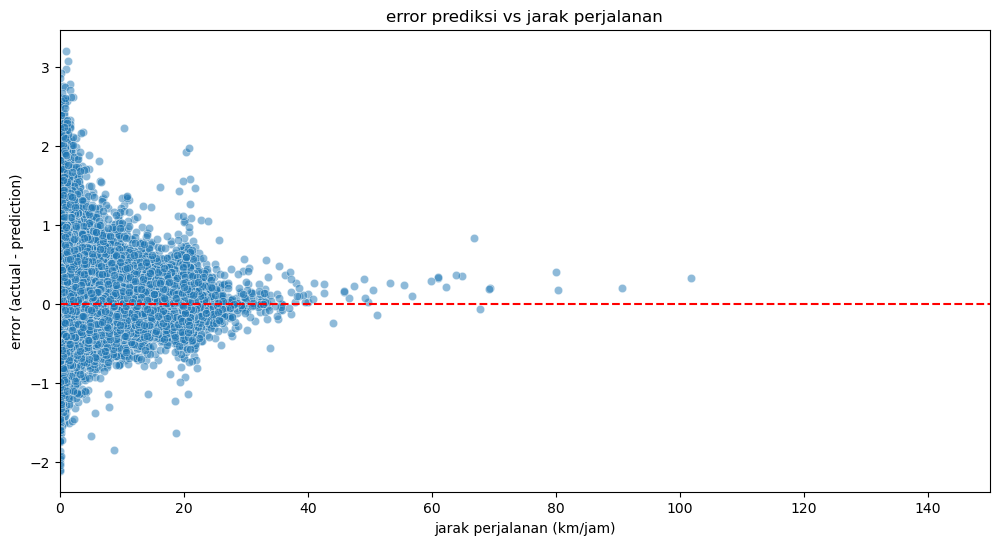

In [216]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='distance_km', y='error', data=df_error_analysis, alpha=0.5)
plt.title('error prediksi vs jarak perjalanan')
plt.xlabel('jarak perjalanan (km/jam)')
plt.ylabel('error (actual - prediction)')
plt.axhline(0, c='red', linestyle='--')
plt.xlim(0,150)
plt.show()


In [176]:
importances = tune_model.feature_importances_
importances

array([0.00576957, 0.00332296, 0.03256477, 0.04374169, 0.03348975,
       0.04514731, 0.0565759 , 0.04319477, 0.6022285 , 0.03711711,
       0.03758712, 0.03242475, 0.02683571], dtype=float32)

In [177]:
df_importances = pd.DataFrame({
        'feature' : final_features,
        'importance': importances
    }).sort_values(by='importance', ascending=False)

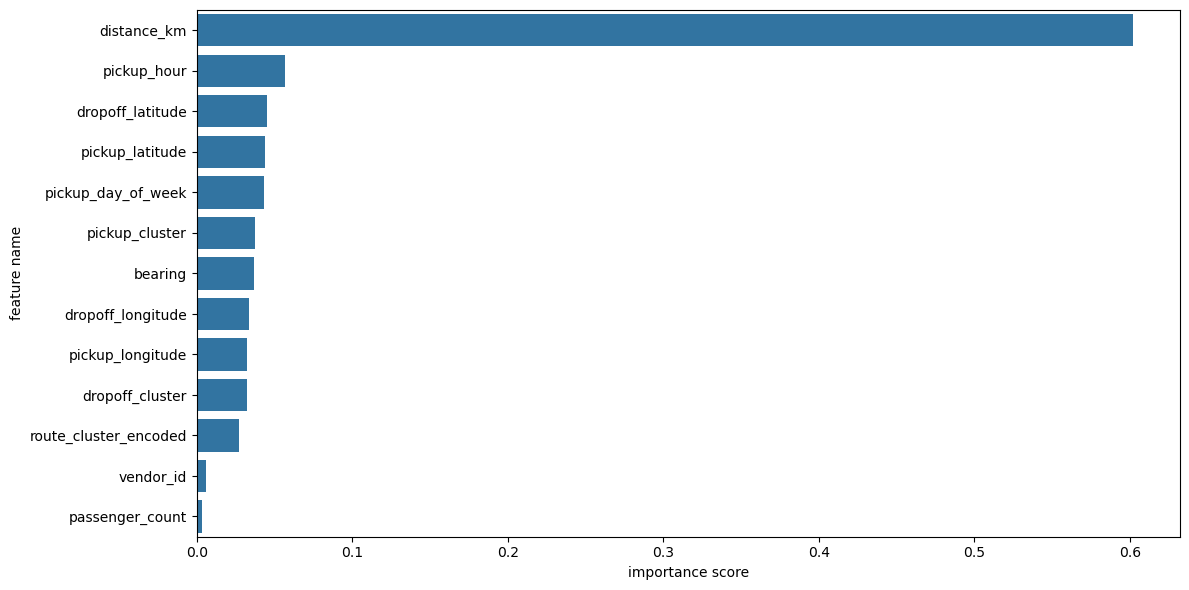

In [178]:
plt.figure(figsize=(12,6))
sns.barplot(data=df_importances, x='importance', y='feature')
plt.xlabel('importance score')
plt.ylabel('feature name')
plt.tight_layout()
plt.show()

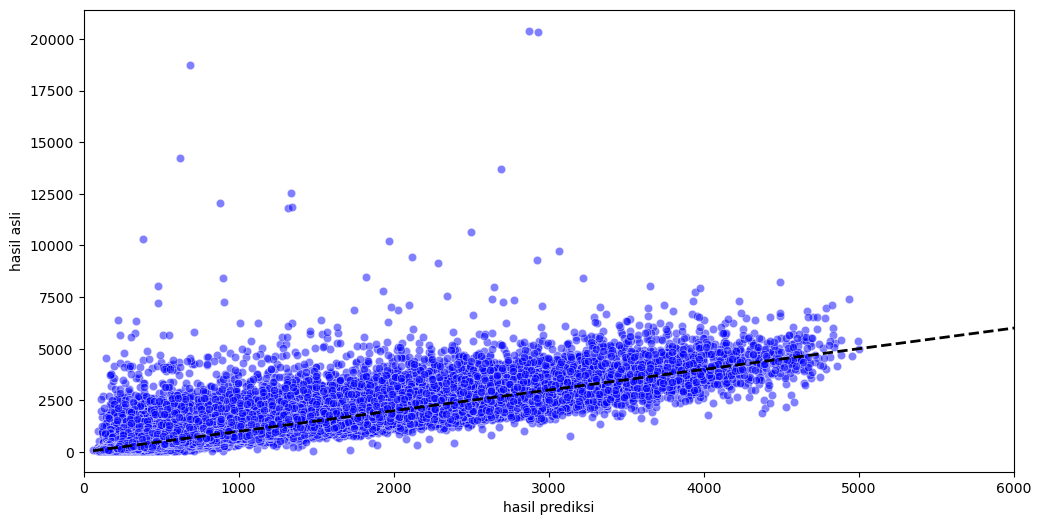

In [217]:
plt.figure(figsize=(12,6))
sns.scatterplot(y=y_test_ori, x=y_pred_ori, color='blue', alpha=0.5)
plt.plot([y_test_ori.min(), y_test_ori.max()], [y_test_ori.min(), y_test_ori.max()],'k--' ,lw=2)
plt.xlabel('hasil prediksi')
plt.ylabel('hasil asli')
plt.xlim(0,6_000)
plt.show()

In [180]:
explainer = shap.TreeExplainer(tune_model)
shap_values = explainer.shap_values(X.sample(5_000, random_state=42))

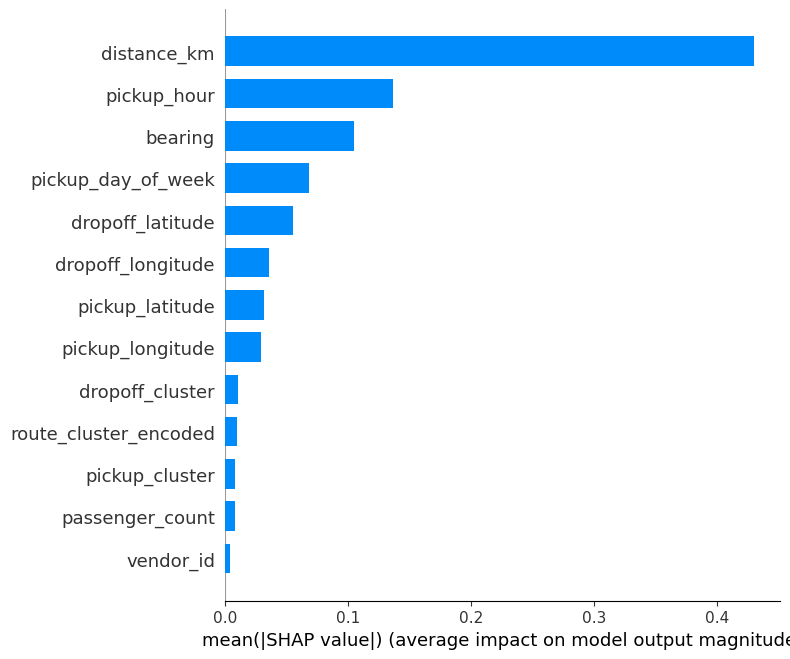

In [181]:
shap.summary_plot(shap_values, X.sample(5_000, random_state=42), plot_type='bar', show=False)

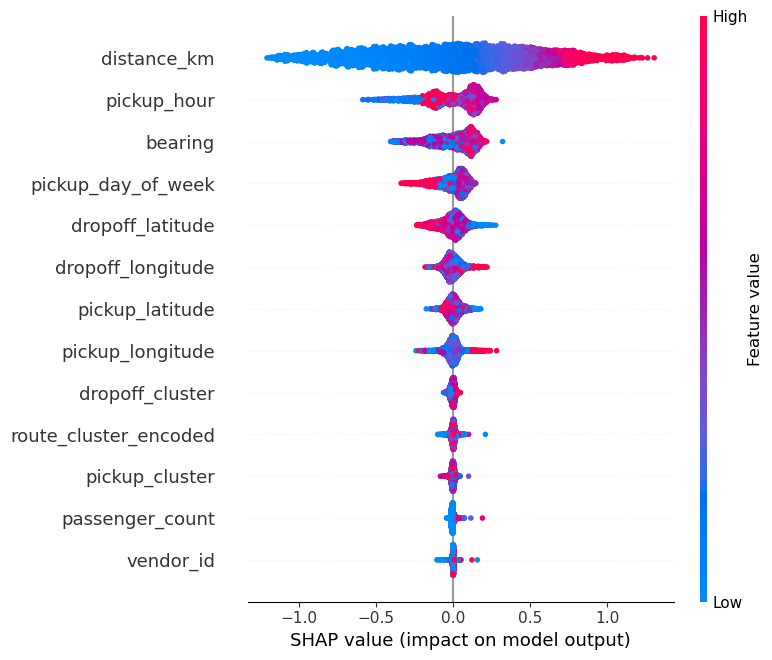

In [182]:
shap.summary_plot(shap_values, X.sample(5_000, random_state=42))


SHAP Dependence Plot untuk distance_km


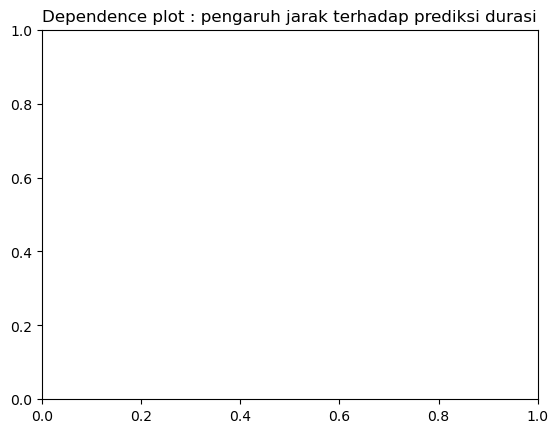

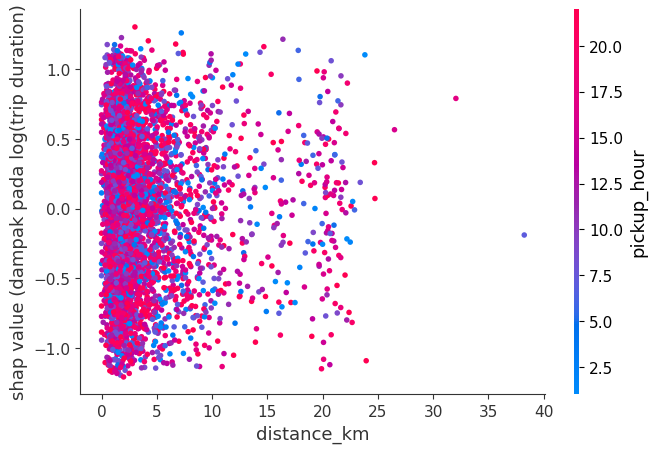

In [183]:
print('\nSHAP Dependence Plot untuk distance_km')
plt.title('Dependence plot : pengaruh jarak terhadap prediksi durasi')
shap.dependence_plot('distance_km', shap_values, X.sample(5_000, random_state=41), interaction_index='pickup_hour', show=False)
plt.ylabel('shap value (dampak pada log(trip duration)')
plt.show()

In [184]:
model_filename = f'{best_model_name}_model.pkl'
kmeans_filename = 'kmeans_model.pkl'

In [185]:
with open(model_filename, 'wb') as f: 
    pickle.dump(tune_model, f)
    print(f'model {best_model_name} berhasil disimpan ke dalam {model_filename}')

with open(kmeans_filename, 'wb') as f: 
    pickle.dump(kmeans_model, f)
    print(f'model K-Means berhasil disimpan kedalam {kmeans_filename}')
    

with open(model_filename, 'rb') as f: 
    loaded_model = pickle.load(f)
    print(f'model {best_model_name} berhasil diload.')

with open(kmeans_filename, 'rb') as f: 
    loaded_kmeans = pickle.load(f)
    print(f'model K-Means berhasil diload.')

model XGBoost berhasil disimpan ke dalam XGBoost_model.pkl
model K-Means berhasil disimpan kedalam kmeans_model.pkl
model XGBoost berhasil diload.
model K-Means berhasil diload.


In [186]:
sample_data = X.head(1).copy()
print('data sample yang mau diprediksi')
print(sample_data)

data sample yang mau diprediksi
   vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
0          2                1        -73.982155        40.767937   

   dropoff_longitude  dropoff_latitude  pickup_hour  pickup_day_of_week  \
0          -73.96463         40.765602           17                   0   

   distance_km    bearing  pickup_cluster  dropoff_cluster  \
0     1.498521  99.970196               5               14   

   route_cluster_encoded  
0                    156  


In [189]:
len(sample_data.columns)

13

In [190]:
ori_pred_log = tune_model.predict(sample_data)
ori_pred_sec = np.expm1(ori_pred_log)

print(f'ori_pred_log = {ori_pred_log}\n')

loaded_pred_log = loaded_model.predict(sample_data)

print(f'prediksi dari model asli : {ori_pred_sec[0]:.2f} detik')
print(f'prediksi dari loaded_pred_log : {loaded_pred_log[0]:.2f} detik')


ori_pred_log = [6.507541]

prediksi dari model asli : 669.18 detik
prediksi dari loaded_pred_log : 6.51 detik


In [191]:
file_name = 'submission_final_tune.csv'
df_final = pd.DataFrame(result_final)
df_final.to_csv(file_name, index=False)
print(f'\nFile {file_name} berhasil dibuat...')
print(df_final)


File submission_final_tune.csv berhasil dibuat...
               id  trip_duration
0       id3004672     838.980652
1       id3505355     572.071106
2       id1217141     392.685211
3       id2150126     880.357361
4       id1598245     371.560577
...           ...            ...
625129  id3008929     241.667358
625130  id3700764    1144.133789
625131  id2568735    1652.762939
625132  id1384355    1873.161865
625133  id0621643    1182.038574

[625134 rows x 2 columns]


In [12]:
# load model
print("*"*20,'load model prediksi & preprocessing',"*"*20)
with open('XGBoost_model.pkl', 'rb') as f:
    final_model = pickle.load(f)
    print('file XGBoost_model.pkl berhasil di load')



print('*'*20,'preparing skenario optimisasi','*'*20)
df_test_op_raw = pd.read_csv('test.csv')

# definisi parameter
NUM_VEHICLES = 4
NUM_CUSTOMERS = 50
DEPOT_INDEX = 0

******************** load model prediksi & preprocessing ********************
file XGBoost_model.pkl berhasil di load
******************** preparing skenario optimisasi ********************


In [6]:
    
with open('kmeans_model.pkl', 'rb') as f:
    kmeans_model = pickle.load(f)
    print('file kmeans_model.pkl berhasil di load')

file kmeans_model.pkl berhasil di load


In [7]:
depot_coords = kmeans_model.cluster_centers_[0]
customer_location = df_test_op_raw.sample(NUM_CUSTOMERS, random_state=42)

depot_coords

array([ 40.70867308, -74.01472129])

In [10]:
data = {
    'latitude' : depot_coords[0],
    'longitude' : depot_coords[1]
}
df_location = pd.DataFrame([data])
df_location

,latitude,longitude
0,40.708673,-74.014721


In [218]:
from ortools.constraint_solver import routing_enums_pb2, pywrapcp
from ortools.linear_solver import pywraplp
from sklearn.preprocessing import LabelEncoder

In [219]:
print("*"*20,'load model prediksi & preprocessing',"*"*20)
try:
    final_model = joblib.load('XGBoost_model.pkl')
    kmeans_model = joblib.load('kmeans_model.pkl')
    print('model berhasil di load')
except FileNotFoundError:
    print('error: pastikan file berada di direktori yang sama')
    exit()

******************** load model prediksi & preprocessing ********************
model berhasil di load


In [225]:
depot_coords = kmeans_model.cluster_centers_[7]
depot_options_2 = {i: f"Zona Depot {i}" for i in range(len(kmeans_model.cluster_centers_))}

print(depot_options_2,'\n')
print(f'depot terpilih :\n{depot_coords}')

{0: 'Zona Depot 0', 1: 'Zona Depot 1', 2: 'Zona Depot 2', 3: 'Zona Depot 3', 4: 'Zona Depot 4', 5: 'Zona Depot 5', 6: 'Zona Depot 6', 7: 'Zona Depot 7', 8: 'Zona Depot 8', 9: 'Zona Depot 9', 10: 'Zona Depot 10', 11: 'Zona Depot 11', 12: 'Zona Depot 12', 13: 'Zona Depot 13', 14: 'Zona Depot 14'} 

depot terpilih :
[ 40.81669803 -73.9443717 ]


In [221]:
NUM_VEHICLES = 4
NUM_CUSTOMERS = 50
DEPOT_INDEX = 0

In [223]:
customer_location = df_test_raw.sample(NUM_CUSTOMERS, random_state=42)
customer_location

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,distance_km,bearing,pickup_cluster,dropoff_cluster,route_cluster,route_cluster_encoded,pickup_hour,pickup_day_of_week
556071,id1993047,1,2016-01-22 01:03:44,1,-73.782387,40.644550,-73.984055,40.740398,N,20.066865,-57.853453,1,10,1_10,92,1,4
26039,id1859197,1,2016-06-23 03:12:39,1,-74.391907,40.719036,-74.391914,40.719048,N,0.001426,-26.806481,4,4,4_4,144,3,3
462559,id0691518,1,2016-02-19 13:46:42,1,-73.995476,40.759659,-73.970993,40.686127,N,8.432690,165.829855,12,11,12_11,48,13,4
531432,id2461411,1,2016-01-30 20:46:14,2,-73.976837,40.764366,-73.987007,40.745197,N,2.297177,-158.101726,5,9,5_9,164,20,5
442137,id3659550,2,2016-02-25 09:30:40,1,-73.972519,40.753754,-73.983231,40.759022,N,1.075721,-57.002466,9,5,9_5,220,9,3
332235,id3408854,1,2016-03-26 22:44:53,1,-73.981613,40.763538,-73.977715,40.747227,N,1.843259,169.736506,5,9,5_9,164,22,5
591891,id1334286,2,2016-01-11 17:15:54,1,-73.957153,40.765057,-73.973282,40.787045,N,2.796815,-29.045596,2,6,2_6,116,17,0
80892,id1801340,2,2016-06-06 18:00:56,1,-73.960983,40.774948,-73.972473,40.784031,N,1.398562,-43.764598,2,6,2_6,116,18,0
284488,id1871235,1,2016-04-09 11:49:50,2,-73.976700,40.776783,-73.984070,40.777721,N,0.629286,-80.452830,6,5,6_5,175,11,5
266096,id3026227,1,2016-04-14 15:30:31,1,-73.976021,40.788868,-73.972000,40.759022,N,3.335970,174.173660,6,14,6_14,171,15,3


In [230]:
df_locations_2 = pd.DataFrame([{'latitude': depot_coords[0], 'longitude': depot_coords[1], 'name': 'Depot'}])
df_customer_coords_2 = customer_location[['pickup_latitude', 'pickup_longitude']].rename(columns={'pickup_latitude':'latitude', 'pickup_longitude':'longitude'})

df_locations_2

,latitude,longitude,name
0,40.816698,-73.944372,Depot


In [233]:
df_customer_coords_2['name'] = [f'Pelanggan {i+1}' for i in range(len(df_customer_coords_2))]
df_locations_2 = pd.concat([df_locations_2, df_customer_coords_2], ignore_index=True)
pd.set_option('display.max_rows', None)
df_locations_2

,latitude,longitude,name
0,40.816698,-73.944372,Depot
1,40.644550,-73.782387,Pelanggan 1
2,40.719036,-74.391907,Pelanggan 2
3,40.759659,-73.995476,Pelanggan 3
4,40.764366,-73.976837,Pelanggan 4
5,40.753754,-73.972519,Pelanggan 5
6,40.763538,-73.981613,Pelanggan 6
7,40.765057,-73.957153,Pelanggan 7
8,40.774948,-73.960983,Pelanggan 8
9,40.776783,-73.976700,Pelanggan 9


In [234]:
data = {
    'latitude' : depot_coords[0],
    'longitude' : depot_coords[1]
}
df_location = pd.DataFrame([data])
df_location

,latitude,longitude
0,40.816698,-73.944372


In [235]:
df_customer_coords = customer_location[['pickup_latitude', 'pickup_longitude']].rename(columns={
        'pickup_latitude': 'latitude',
        'pickup_longitude': 'longitude'
    })
df_location = pd.concat([df_location, df_customer_coords], ignore_index=True)
print(f'skenario dibuat 1 depot, {NUM_CUSTOMERS} pelanggan, dan {NUM_VEHICLES} kendaraan')

skenario dibuat 1 depot, 50 pelanggan, dan 4 kendaraan


In [237]:
df_location

,latitude,longitude
0,40.816698,-73.944372
1,40.644550,-73.782387
2,40.719036,-74.391907
3,40.759659,-73.995476
4,40.764366,-73.976837
5,40.753754,-73.972519
6,40.763538,-73.981613
7,40.765057,-73.957153
8,40.774948,-73.960983
9,40.776783,-73.976700


In [238]:
final_features

['vendor_id',
 'passenger_count',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'pickup_hour',
 'pickup_day_of_week',
 'distance_km',
 'bearing',
 'pickup_cluster',
 'dropoff_cluster',
 'route_cluster_encoded']

In [239]:
print("\nMembuat matriks waktu perjalanan (cost matrix)... Ini mungkin butuh waktu.")
num_locations = len(df_location)
time_matrix = np.zeros((num_locations, num_locations), dtype=int)
print(num_locations)
print(time_matrix)


Membuat matriks waktu perjalanan (cost matrix)... Ini mungkin butuh waktu.
51
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [242]:
start_hour = 9
start_day = 1

for from_node in range(num_locations):
    for to_node in range(num_locations):
        if from_node == to_node:
            continue
        start_lat, start_lon = df_location.iloc[from_node][['latitude','longitude']]
        end_lat, end_lon = df_location.iloc[to_node][['latitude', 'longitude']]
        travel_time = int(np.expm1(y_pred_log)[0])
        time_matrix[from_node, to_node] = travel_time
        

print('matriks waktu sudah selesai dibuat')

matriks waktu sudah selesai dibuat


In [243]:
travel_time

466

In [244]:
manager = pywrapcp.RoutingIndexManager(num_locations, NUM_VEHICLES, DEPOT_INDEX)
routing = pywrapcp.RoutingModel(manager)

def time_callback(from_idx, to_idx):
    from_node = manager.IndexToNode(from_idx)
    to_node = manager.IndexToNode(to_idx)
    return time_matrix[from_node, to_node]



In [245]:
transit_callback_idx = routing.RegisterTransitCallback(time_callback)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_idx)

routing.AddDimension(transit_callback_idx, 0, 28800, True, 'Time')
time_dimension = routing.GetDimensionOrDie('Time')
time_dimension.SetGlobalSpanCostCoefficient(100)

search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )
solution = routing.SolveWithParameters(search_parameters)

In [248]:
def print_solution(manager, routing, solution, df_location):
    print(f'tujuan (total waktu) = {solution.ObjectiveValue()} detik')
    total_time=0
    route_times = []
    
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(14,14))
    colors = plt.cm.get_cmap('gist_rainbow', NUM_VEHICLES)
    
    for vehicle_id in range(manager.GetNumberOfVehicles()):
        idx = routing.Start(vehicle_id)
        plan_output = f'rute untuk kendaraan {vehicle_id} :\n'
        route_time = 0
        route_node = []
        
        while not routing.IsEnd(idx):
            node_idx = manager.IndexToNode(idx)
            route_node.append(node_idx)
            previous_idx = idx
            idx = solution.Value(routing.NextVar(idx))
            route_time += routing.GetArcCostForVehicle(previous_idx, idx, vehicle_id)
            plan_output += f'  {node_idx} -->'
            
        node_idx = manager.IndexToNode(idx)
        route_node.append(node_idx)
        plan_output += f'  {node_idx}\n'
        plan_output += f'Total waktu rute = {route_time} detik ({route_time/3600:.2f} jam)\n'
        print(plan_output)
        total_time += route_time
        
        if len(route_node) > 1 :
            route_lats = df_location.iloc[route_node]['latitude']
            route_lons = df_location.iloc[route_node]['longitude']
            ax.plot(route_lons, route_lats, marker='o', linestyle='-', color=colors(vehicle_id), label=f'kendaraan {vehicle_id}')
            
        print("\n" + "="*40)
        print("       ANALISIS BIAYA (COST ANALYSIS)")
        print("="*40)
        total_penalty = solution.ObjectiveValue() - total_time
        print(f'Total Waktu Perjalanan (Biaya Utama) : {total_time} detik --> {total_time/3600:.2f} jam')
        print(f'Total Biaya Penalti Keseimbangan     : {total_penalty} detik --> {total_penalty/3600:.2f} jam')
        print(f'Nilai Tujuan (Objective Value) Final : {solution.ObjectiveValue()} detik (Waktu + Penalti) --> {solution.ObjectiveValue()/3600:.2f} jam')
    
        if route_times:
            min_time = min(route_times)
            max_time = max(route_times)
            span = max_time - min_time
            print(f"\nDurasi Rute Terpanjang: {max_time} detik")
            print(f"Durasi Rute Terpendek : {min_time} detik")
            print(f"Perbedaan (Span)      : {span} detik")
        print("=" * 40 + "\n")

    print(f'total waktu untuk semua rute : {total_time} detik ({total_time/3600:.2f} jam)')
        
    ax.scatter(df_location.iloc[0]['longitude'], df_location.iloc[0]['latitude'], c='white', s=200, marker='s', label='Depot')
    ax.set_title('visualisasi rute optimal', fontsize=16)
    ax.set_xlabel('longitude', fontsize=12)
    ax.set_ylabel('latitude', fontsize=12)
    ax.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()
    print(f'route_node = {route_node}')



tujuan (total waktu) = 1235832 detik
rute untuk kendaraan 0 :
  0 -->  26 -->  27 -->  28 -->  29 -->  30 -->  31 -->  32 -->  33 -->  34 -->  35 -->  36 -->  37 -->  38 -->  39 -->  40 -->  41 -->  42 -->  43 -->  44 -->  45 -->  46 -->  47 -->  48 -->  49 -->  50 -->  0
Total waktu rute = 12116 detik (3.37 jam)


       ANALISIS BIAYA (COST ANALYSIS)
Total Waktu Perjalanan (Biaya Utama) : 12116 detik --> 3.37 jam
Total Biaya Penalti Keseimbangan     : 1223716 detik --> 339.92 jam
Nilai Tujuan (Objective Value) Final : 1235832 detik (Waktu + Penalti) --> 343.29 jam

rute untuk kendaraan 1 :
  0 -->  0
Total waktu rute = 0 detik (0.00 jam)


       ANALISIS BIAYA (COST ANALYSIS)
Total Waktu Perjalanan (Biaya Utama) : 12116 detik --> 3.37 jam
Total Biaya Penalti Keseimbangan     : 1223716 detik --> 339.92 jam
Nilai Tujuan (Objective Value) Final : 1235832 detik (Waktu + Penalti) --> 343.29 jam

rute untuk kendaraan 2 :
  0 -->  0
Total waktu rute = 0 detik (0.00 jam)


       ANALISIS B

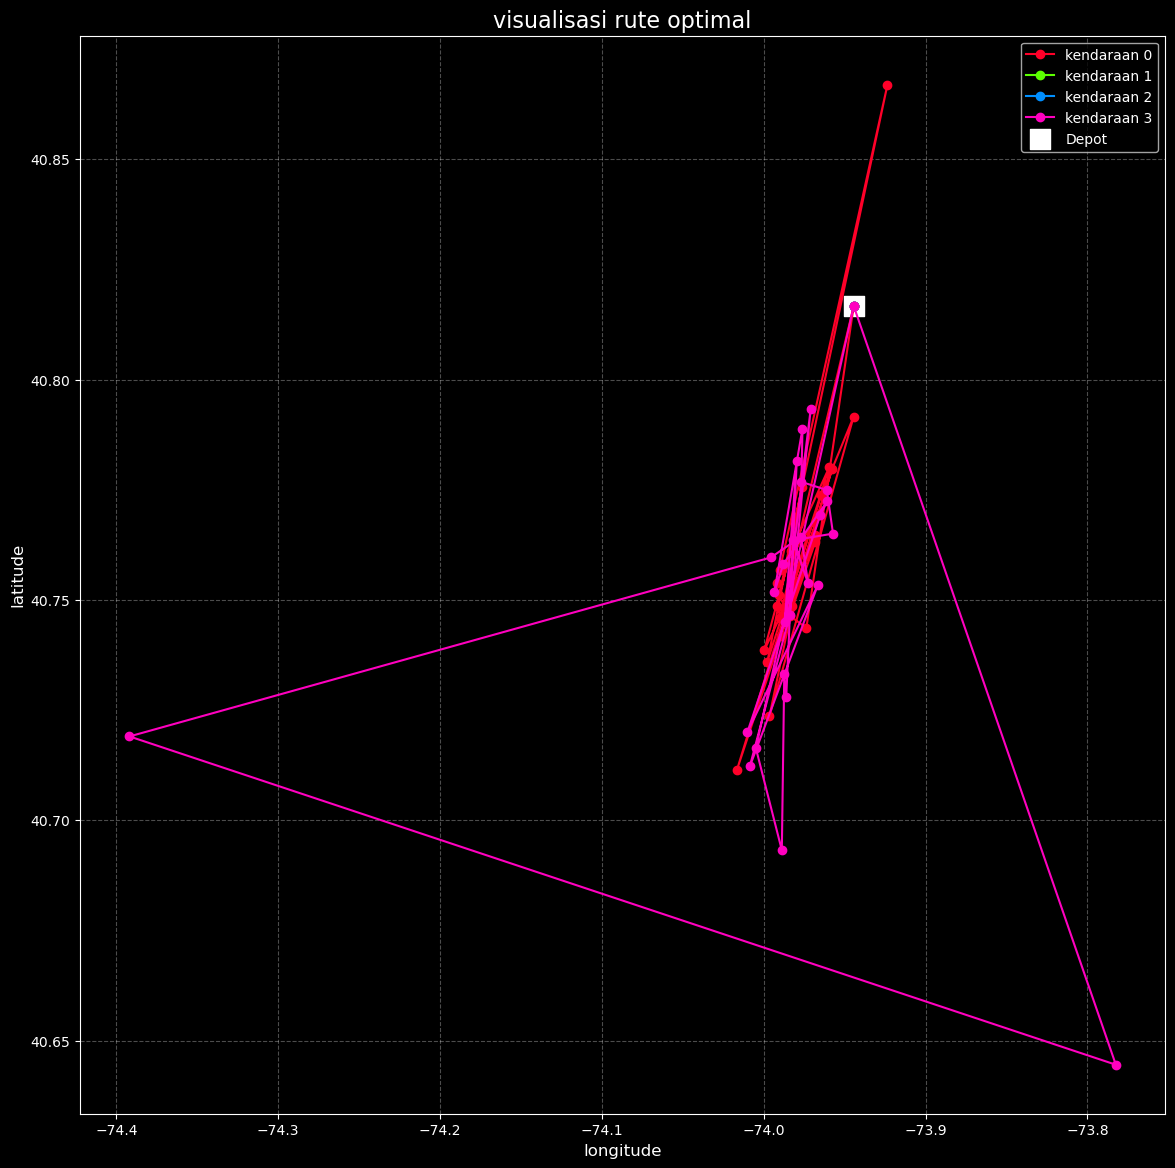

route_node = [0, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]


In [249]:
if solution:
    print_solution(manager, routing, solution, df_location)
else:
    print('solusi engga di temukan')
        